In [1]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.transforms import ToTensor, ToPILImage, Lambda
import matplotlib.pyplot as plt
import math

import pandas as pd
from torchvision.io import read_image

In [2]:
class CosmosimImageDataset(Dataset):
    def __init__(self, root, annotations_filename='labels.csv', img_dir='images', train=True, transform=None, target_transform=None):
        df = pd.read_csv('{0}/{1}'.format(root.rstrip('/'), annotations_filename.lstrip('/')))
        if train:
            self.img_labels = df.head(math.floor(0.8 * len(df)))
        else:
            self.img_labels = df.tail(len(df) - math.floor(0.8 * len(df)))
        self.img_dir = '{0}/{1}'.format(root.rstrip('/'), img_dir.lstrip('/'))
        self.transform = transform
        self.target_transform = target_transform
        self.classes = list(self.img_labels.iloc[: , 1:].columns)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        labels = self.img_labels.iloc[idx, 1:]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)
        return image.float(), labels.float()

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100*100, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 15)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer, device = None):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, device = None):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error: \n, Avg loss: {test_loss:>8f} \n")

In [5]:
root = "__local/data/Cosmosim/2"
training_data = CosmosimImageDataset(
    root=root,
    train=True,
    transform=Lambda(lambda y: ToTensor()(ToPILImage()(y))),
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)

test_data = CosmosimImageDataset(
    root=root,
    train=False,
    transform=Lambda(lambda y: ToTensor()(ToPILImage()(y))),
    target_transform=None
)

In [6]:
training_data.img_labels

,name,r_ein,rdsf_l,r_eff_l,x_l,y_l,ellx_l,elly_l,int_l,rdsf_s,r_eff_s,x_s,y_s,ellx_s,elly_s,int_s
0,ghev4z.png,2.293668,0.525671,1.950483,-0.422019,0.624025,-0.331191,-0.053357,0.126337,1.970507,1.574193,0.931037,0.636737,-0.489197,-0.459486,1.965517
1,wv0ifv.png,1.311838,0.496409,0.311542,0.570147,-0.512536,0.401570,-0.157585,1.113677,2.325273,1.298236,-0.712530,-0.413957,0.411366,0.261754,1.136425
2,mh5l9v.png,0.595836,0.481766,1.802882,0.750459,-0.019812,0.057349,0.380889,1.239945,1.560775,1.279680,-0.267618,-0.881755,-0.208026,-0.297626,1.932651
3,xqlbt7.png,1.567681,0.478053,0.399903,0.332311,-0.342499,0.092276,-0.486754,1.733667,1.560970,1.934960,0.393116,0.281614,-0.381952,0.366178,1.943175
4,n79pcv.png,1.718395,0.446315,0.153358,-0.715616,0.652604,-0.445466,-0.327108,1.225025,2.149423,1.636905,0.661124,0.275720,0.373174,0.315058,1.117356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,0v483x.png,2.262744,0.623743,0.529243,0.900723,0.982835,0.394459,-0.112194,0.291258,2.314383,1.704424,-0.337585,0.634382,0.414693,-0.380872,1.514263
47996,5zs33e.png,0.907046,0.697428,0.864830,0.977942,0.529336,0.129476,0.194737,0.049055,2.462529,1.596220,-0.808584,-0.055311,0.387548,-0.353572,1.904903
47997,116bai.png,2.140756,0.656870,1.794460,-0.628888,-0.331966,0.407345,-0.138772,1.181272,2.107097,1.669506,-0.444864,0.577810,0.074298,-0.475709,1.619548
47998,tzfqjh.png,2.385122,0.454650,1.751315,-0.261611,0.871268,-0.119952,0.132227,0.863376,1.820274,0.217131,-0.957758,-0.271021,-0.054043,0.176370,1.940140


In [7]:
test_data.img_labels

,name,r_ein,rdsf_l,r_eff_l,x_l,y_l,ellx_l,elly_l,int_l,rdsf_s,r_eff_s,x_s,y_s,ellx_s,elly_s,int_s
48000,qxepb2.png,1.574042,0.669840,1.636849,0.924641,-0.616865,0.353301,0.485757,0.233355,2.263180,1.338242,0.267566,0.371795,-0.209316,-0.492679,1.966898
48001,b0gq8h.png,2.835566,0.673942,0.223298,0.502303,0.844784,0.355405,-0.488402,0.367189,2.134062,0.793786,0.288723,-0.694613,0.318671,-0.485163,0.739084
48002,6j7l7v.png,1.790545,0.596876,1.432469,-0.518552,-0.977151,-0.231548,0.244795,1.437537,1.693540,0.773612,0.056587,0.871027,0.460095,-0.257746,0.415718
48003,zzp7fl.png,1.951171,0.597225,0.387204,0.080594,0.269244,-0.328056,0.498685,0.068594,1.851771,0.468069,-0.350706,0.121794,0.229636,-0.015150,0.792788
48004,jv6k6k.png,0.889883,0.691902,1.884465,-0.911545,-0.245866,0.415931,-0.164884,0.848880,1.562253,0.512480,-0.464863,-0.546445,0.426101,0.007859,0.032658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8181ix.png,1.664590,0.561766,0.376403,-0.850136,0.194711,-0.209978,-0.280533,1.751917,2.240776,0.104952,-0.839230,-0.863409,-0.224544,-0.176378,0.619767
59996,hem6p2.png,0.646991,0.663638,0.221396,-0.127408,-0.572290,-0.388372,-0.478428,1.122433,2.465862,1.565338,-0.078033,0.816104,0.336415,0.294529,1.163279
59997,hooqge.png,2.058020,0.490094,0.344369,-0.129430,0.283676,0.076873,0.247104,1.711002,1.967507,0.527750,-0.182005,-0.192137,-0.124240,-0.035426,0.776749
59998,c015rm.png,1.320222,0.582861,0.691238,0.233765,0.218718,0.033273,-0.256981,1.462177,2.462988,1.460740,-0.582336,-0.712588,-0.067520,0.222409,0.334771


In [8]:
training_data.classes

['r_ein',
 'rdsf_l',
 'r_eff_l',
 'x_l',
 'y_l',
 'ellx_l',
 'elly_l',
 'int_l',
 'rdsf_s',
 'r_eff_s',
 'x_s',
 'y_s',
 'ellx_s',
 'elly_s',
 'int_s']

In [9]:
labels_map = training_data.img_labels.r_ein
labels_map

0        2.293668
1        1.311838
2        0.595836
3        1.567681
4        1.718395
           ...   
47995    2.262744
47996    0.907046
47997    2.140756
47998    2.385122
47999    2.325223
Name: r_ein, Length: 48000, dtype: float64

In [10]:
idx = 0
img, label = training_data[idx]
print(label)

tensor([ 2.2937,  0.5257,  1.9505, -0.4220,  0.6240, -0.3312, -0.0534,  0.1263,
         1.9705,  1.5742,  0.9310,  0.6367, -0.4892, -0.4595,  1.9655])


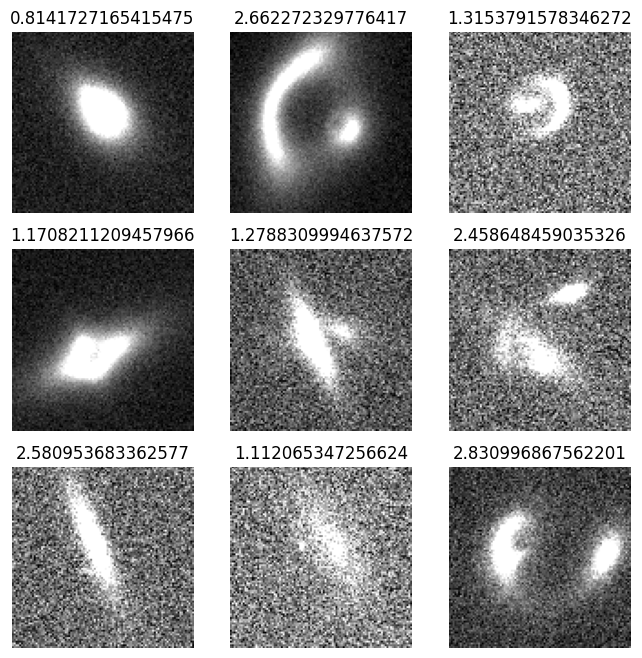

In [11]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[sample_idx])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [12]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 100, 100])
Labels batch shape: torch.Size([64, 15])


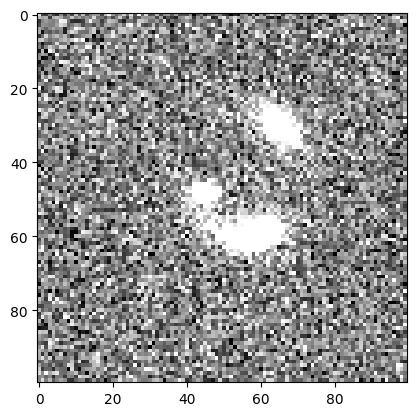

Label: tensor([ 1.9625,  0.5452,  0.9737,  0.0985,  0.2054, -0.3912,  0.4419,  0.0363,
         2.4523,  0.2761,  0.4736,  0.7697, -0.1581,  0.0149,  1.7075])


In [13]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [14]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [15]:
model = CNN().to(device)

In [16]:
learning_rate = 1e-3
epochs = 10

In [17]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.055407  [   64/48000]
loss: 0.197854  [ 6464/48000]
loss: 0.176278  [12864/48000]
loss: 0.162549  [19264/48000]
loss: 0.164502  [25664/48000]
loss: 0.157569  [32064/48000]
loss: 0.163489  [38464/48000]
loss: 0.147997  [44864/48000]
Test Error: 
, Avg loss: 0.152557 

Epoch 2
-------------------------------
loss: 0.148091  [   64/48000]
loss: 0.134772  [ 6464/48000]
loss: 0.141528  [12864/48000]
loss: 0.147196  [19264/48000]
loss: 0.144261  [25664/48000]
loss: 0.146541  [32064/48000]
loss: 0.133701  [38464/48000]
loss: 0.126029  [44864/48000]
Test Error: 
, Avg loss: 0.133834 

Epoch 3
-------------------------------
loss: 0.122262  [   64/48000]
loss: 0.122397  [ 6464/48000]
loss: 0.114674  [12864/48000]
loss: 0.122429  [19264/48000]
loss: 0.117865  [25664/48000]
loss: 0.130011  [32064/48000]
loss: 0.134582  [38464/48000]
loss: 0.118443  [44864/48000]
Test Error: 
, Avg loss: 0.131419 

Epoch 4
-------------------------------
loss: 0.1253

In [20]:
torch.save(model.state_dict(), '__local/models/model_cnn_50k.pth')

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100*100, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 15)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [19]:
model = NeuralNetwork().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.022739  [   64/48000]
loss: 0.201651  [ 6464/48000]
loss: 0.161754  [12864/48000]
loss: 0.175294  [19264/48000]
loss: 0.176219  [25664/48000]
loss: 0.156377  [32064/48000]
loss: 0.168902  [38464/48000]
loss: 0.158913  [44864/48000]
Test Error: 
, Avg loss: 0.148926 

Epoch 2
-------------------------------
loss: 0.146566  [   64/48000]
loss: 0.149636  [ 6464/48000]
loss: 0.158061  [12864/48000]
loss: 0.143173  [19264/48000]
loss: 0.134462  [25664/48000]
loss: 0.150245  [32064/48000]
loss: 0.138892  [38464/48000]
loss: 0.128175  [44864/48000]
Test Error: 
, Avg loss: 0.136131 

Epoch 3
-------------------------------
loss: 0.136281  [   64/48000]
loss: 0.123745  [ 6464/48000]
loss: 0.131344  [12864/48000]
loss: 0.125596  [19264/48000]
loss: 0.114080  [25664/48000]
loss: 0.128652  [32064/48000]
loss: 0.121320  [38464/48000]
loss: 0.127598  [44864/48000]
Test Error: 
, Avg loss: 0.127703 

Epoch 4
-------------------------------
loss: 0.1143

In [18]:
root = "__local/data/Cosmosim/3"
transform = transforms.Compose([
    transforms.Resize(256, antialias=None),
    transforms.CenterCrop(224),
    transforms.ToPILImage(),
    transforms.ToTensor()
])

training_data = CosmosimImageDataset(
    root=root,
    train=True,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)

test_data = CosmosimImageDataset(
    root=root,
    train=False,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [19]:
alexnet = models.alexnet(weights='IMAGENET1K_V1')
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [20]:
alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
alexnet.classifier[6] = nn.Linear(4096, 15)

In [21]:
alexnet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [22]:
loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(alexnet.parameters(), lr=0.001)
learning_rate = 1e-3
epochs = 10

In [23]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, alexnet, loss_fn, optimiser, device)
    test_loop(test_dataloader, alexnet, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 1.110849  [   64/800000]
loss: 0.212360  [ 6464/800000]
loss: 0.176920  [12864/800000]
loss: 0.178226  [19264/800000]
loss: 0.173639  [25664/800000]
loss: 0.149958  [32064/800000]
loss: 0.143491  [38464/800000]
loss: 0.135673  [44864/800000]
loss: 0.139532  [51264/800000]
loss: 0.123774  [57664/800000]
loss: 0.100536  [64064/800000]
loss: 0.111886  [70464/800000]
loss: 0.114228  [76864/800000]
loss: 0.121146  [83264/800000]
loss: 0.100090  [89664/800000]
loss: 0.092612  [96064/800000]
loss: 0.091585  [102464/800000]
loss: 0.092226  [108864/800000]
loss: 0.105835  [115264/800000]
loss: 0.090016  [121664/800000]
loss: 0.100315  [128064/800000]
loss: 0.094227  [134464/800000]
loss: 0.110197  [140864/800000]
loss: 0.102024  [147264/800000]
loss: 0.111468  [153664/800000]
loss: 0.093370  [160064/800000]
loss: 0.095599  [166464/800000]
loss: 0.096339  [172864/800000]
loss: 0.073350  [179264/800000]
loss: 0.090417  [185664/800000]
loss: 0.086136  

In [25]:
torch.save(alexnet.state_dict(), '__local/models/model_alexnet_1m.pth')